Import necessary modules

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
import cv2
import numpy as np

from google.colab import drive
import os
drive.mount('/content/drive')
data_dir = '/content/drive/Shared drives/ITK Ultrasound Consultation/Zoé_szakdolgozat/data/other_imaging_modalities/images'
#output_dir = '/content/drive/Shared drives/ITK Ultrasound Consultation/Zoé_szakdolgozat/data/other_imaging_modalities/style_transfer_700_0.5M_images'
output_dir = '/content/drive/Shared drives/ITK Ultrasound Consultation/Zoé_szakdolgozat/co_1_NEVUS_experiments/images'
if not os.path.exists(output_dir):
  os.mkdir(output_dir)

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

In [ ]:
loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

In [ ]:
def content_image_loader(image_name):
    image = Image.open(image_name)
    image = ImageOps.grayscale(image)
    original_shape = (image.height, image.width)
    image = image.resize((444,444))  #I resize the input image to 444x444
    # fake batch dimension required to fit network's input dimensions
    #print(image.size)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float), original_shape

In [ ]:
def style_image_loader(image_name):
  #biztos lehet szebben is, de én csak így tudtam megcsinálni
    img = cv2.imread(image_name,0) #grayscale
    original_shape = img.shape
    img = cv2.resize(img,(444,444))
    img = (img-np.amin(img))/(np.amax(img)-np.amin(img)) #normalization
    img2 = Image.fromarray(img)
    img2 = loader(img2).unsqueeze(0)
    return img2.to(device, torch.float), original_shape

In [ ]:
style_img, cucc = style_image_loader("/content/drive/Shared drives/ITK Ultrasound Consultation/Zoé_szakdolgozat/hitachi_style_transfer_sample/130.png") #under construction
print(cucc)
#content_img = image_loader("RefUS_020_2b.jpg")

#assert style_img.size() == content_img.size(), \
#    "we need to import style and content images of the same size"

(417, 986)


In [ ]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

In [ ]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

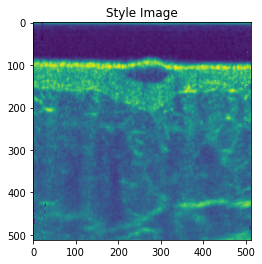

In [ ]:
plt.ion()
plt.figure()
imshow(style_img, title='Style Image')
#plt.savefig("Style.png")
#plt.figure()
#imshow(content_img, title='Content Image')
#plt.savefig("Content.png")

Define Content and Style Losses for the network

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
        
def gram_matrix(input):
    a, b, c, d = input.size()
    # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)
    
    
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        #mean squared error
        #a target és az input gram mátrixa mennyire tér el
        #a cikkek szerint nem veszi figyelembe a térbeli elrendezést 
        self.loss = F.mse_loss(G, self.target)
        return input
 

Generate network - downloads weights on first run

In [ ]:
# vgg19 eval módban
cnn = models.vgg19(pretrained=True).features.to(device).eval()
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [ ]:
content_layers_default = ['conv_4'] 
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


In [ ]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    
    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [ ]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    #print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    #Kiírom fájlba a model rétegeit
    with open("model.txt", 'w') as file_out:
      for module in model.children():
        file_out.write(str(module) + "\n")
    
    #print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:
        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            """
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()
            """
            if run[0] == num_steps:
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()
            return style_score + content_score
        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img

In [ ]:
def save_img(img, img_shape, path):
  #out_img_tensor = torch.transpose(torch.transpose(img.cpu().detach().squeeze(), 0,1), 1,2)
  out_img_tensor = img.cpu().detach().squeeze()
  out_img_np = np.array(out_img_tensor)*255
  out_img_np = out_img_np.astype('uint8')

  rgb = cv2.cvtColor(out_img_np, cv2.COLOR_BGR2RGB)
  w,h=img_shape
  rgb = cv2.resize(rgb, (h,w))
  cv2.imwrite(path, rgb)

In [ ]:
for steps in range(100,1050,50):
  content_img, original_shape = content_image_loader(os.path.join(data_dir, 'co_1_NEVUS_cropped.png'))
  input_img = content_img.clone()
  output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                              content_img, style_img, input_img, num_steps=steps, style_weight=500000)
  #imshow(output, title='ha_23_MELA')
  save_img(output, original_shape, os.path.join(output_dir,str(steps)+'_co_1_NEVUS.png'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, cei

Style Loss : 2.368631 Content Loss: 5.680809

Style Loss : 1.715490 Content Loss: 5.141418

Style Loss : 1.171564 Content Loss: 4.815987

Style Loss : 0.904497 Content Loss: 4.692558

Style Loss : 0.758786 Content Loss: 4.618811

Style Loss : 0.637381 Content Loss: 4.576050

Style Loss : 0.511494 Content Loss: 4.546432

Style Loss : 0.456396 Content Loss: 4.511897

Style Loss : 0.430338 Content Loss: 4.484078

Style Loss : 0.402550 Content Loss: 4.458250

Style Loss : 0.367270 Content Loss: 4.452299

Style Loss : 0.351290 Content Loss: 4.438100

Style Loss : 0.338814 Content Loss: 4.420679

Style Loss : 0.327215 Content Loss: 4.408143

Style Loss : 0.322644 Content Loss: 4.392887

Style Loss : 0.320203 Content Loss: 4.389217

Style Loss : 0.318958 Content Loss: 4.385597

Style Loss : 0.318538 Content Loss: 4.372642

Style Loss : 0.316569 Content Loss: 4.371733



In [ ]:
file_list = os.listdir(data_dir)

file_list.sort()
for f in file_list:
  #we don't transfer Hitachi images to Hitachi style
  #if the image was made with Cortex or Draminski it has to be cropped
  if not f.startswith('hi_') and (not (f.startswith('co_') or f.startswith('dr_')) or (f.endswith('cropped.png'))):
    print(f)
    content_img, original_shape = content_image_loader(os.path.join(data_dir, f))
    input_img = content_img.clone()
    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=700, style_weight=500000)
    save_img(output, original_shape, os.path.join(output_dir, f))

co_10_NEVUS_cropped.png


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, cei

Style Loss : 0.383362 Content Loss: 3.603564

co_11_NEVUS_cropped.png
Style Loss : 0.388539 Content Loss: 3.490481

co_1_NEVUS_cropped.png
Style Loss : 0.331967 Content Loss: 4.419219

co_2_NEVUS_cropped.png
Style Loss : 0.348675 Content Loss: 3.609923

co_3_NEVUS_cropped.png
Style Loss : 0.358363 Content Loss: 3.595426

co_4_NEVUS_cropped.png
Style Loss : 0.389634 Content Loss: 3.620981

co_5_NEVUS_cropped.png
Style Loss : 0.388771 Content Loss: 3.780330

co_6_NEVUS_cropped.png
Style Loss : 0.386217 Content Loss: 3.671509

co_7_NEVUS_cropped.png
Style Loss : 0.368576 Content Loss: 4.076472

co_8_NEVUS_cropped.png
Style Loss : 0.354951 Content Loss: 3.797847

co_9_NEVUS_cropped.png
Style Loss : 0.356872 Content Loss: 3.653624

dr_1_UNKNOWN_cropped.png
Style Loss : 0.250430 Content Loss: 3.411652

dr_2_UNKNOWN_cropped.png
Style Loss : 0.260553 Content Loss: 3.092369

dr_3_UNKNOWN_cropped.png
Style Loss : 15.403051 Content Loss: 14.187193

dr_4_UNKNOWN_cropped.png
Style Loss : 0.241415 C